In [1]:
#import stuff
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# dimensions of our images, file locations, train samples, batch (samples need to be dibisible by the batch size)
img_width = 1440
img_height = 900

train_data_dir = r'C:\Users\VAS2AGU\Desktop\GF FaReC v0\data\train' 
validation_data_dir = r'C:\Users\VAS2AGU\Desktop\GF FaReC v0\data\validate'
nb_train_samples = 64
nb_validation_samples = 64
epochs = 50
batch_size = 16
model_file_name = 'GF FaReC run1.h5'

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_height, img_width)
else:
    input_shape = (img_height, img_width, 3)

In [3]:
# Model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)

model.add(Flatten()) # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [4]:
# maybe Adam to get out of local and find Global objectives?

# from keras.optimizers import Adam
# opt = Adam(lr=0.001)
# model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 898, 1438, 32)     896       
_________________________________________________________________
activation_1 (Activation)    (None, 898, 1438, 32)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 449, 719, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 447, 717, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 447, 717, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 223, 358, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 221, 356, 64)     

In [6]:
# Augmentations
# this is the augmentation configuration we will use for training
# no many augmentations for this due to the nature of the data
train_datagen = ImageDataGenerator(
    rescale=1. / 255)
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling, same as for training
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [10]:
# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
    train_data_dir, # this is the target directory
    target_size=(img_height, img_width), # all images will be resized to the size we required (important to be height, width)
    batch_size=batch_size,
    class_mode='binary') # since we use binary_crossentropy loss, we need binary labels IMPORTANT

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 64 images belonging to 2 classes.
Found 64 images belonging to 2 classes.


In [11]:
# now to train
# model.fit_generator(
#     train_generator,
#     steps_per_epoch=nb_train_samples // batch_size,
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=nb_validation_samples // batch_size)

# model.save_weights('GF FaReC run2.h5') 
# always save your weights after training or during training

In [12]:
# attemt to train based on de accuracy of the model 

# save only the best model obtained according to val_acc
checkpoint = ModelCheckpoint(
    model_file_name, monitor='val_accuracy', verbose=1, 
    save_best_only=True, save_weights_only=False, 
    mode='auto', period=1)

early = EarlyStopping(
    monitor='val_accuracy', min_delta=0, 
    patience=20, verbose=1, mode='auto')

# hist = model.fit_generator(steps_per_epoch=100, 
#                            generator=traindata, 
#                            validation_data= testdata, 
#                            validation_steps=10,epochs=100,
#                            callbacks=[checkpoint,early])

hist = model.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size, 
    epochs=epochs, 
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size, 
    callbacks=[checkpoint, early])


Epoch 1/50
4/4 [==============================] - 67s 17s/step - loss: 18.4085 - accuracy: 0.4844 - val_loss: 3.9537 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to GF FaReC run1.h5
Epoch 2/50
4/4 [==============================] - 58s 15s/step - loss: 1.3598 - accuracy: 0.7188 - val_loss: 0.1994 - val_accuracy: 0.9844

Epoch 00002: val_accuracy improved from 0.50000 to 0.98438, saving model to GF FaReC run1.h5
Epoch 3/50
4/4 [==============================] - 58s 14s/step - loss: 0.2122 - accuracy: 0.9375 - val_loss: 0.0207 - val_accuracy: 0.9688

Epoch 00003: val_accuracy did not improve from 0.98438
Epoch 4/50
4/4 [==============================] - 58s 15s/step - loss: 0.2321 - accuracy: 0.9375 - val_loss: 0.0065 - val_accuracy: 1.0000

Epoch 00004: val_accuracy improved from 0.98438 to 1.00000, saving model to GF FaReC run1.h5
Epoch 5/50
4/4 [==============================] - 59s 15s/step - loss: 0.0536 - accuracy: 0.9844 - val_loss:

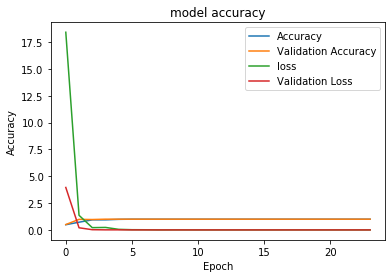

In [13]:
# Graph accuracy of our model

plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()


False Reject


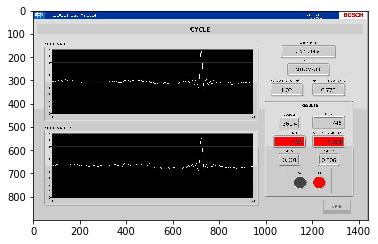

In [33]:
# Check if a test image is categorized correctly

img_path = r"C:\Users\VAS2AGU\Desktop\GF FaReC v0\Test 1.jpg"
img = image.load_img(img_path,target_size=(img_height, img_width))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
#images = np.vstack([img])

saved_model = load_model(model_file_name)
output = saved_model.predict(img)
#print(output)

if output[0][0] == 1:
    print("Pinched")
else:
    print("False Reject")
